# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of
the integration. Let’s load those:

In [2]:
link_stats = pd.read_csv("book-links/gender-stats.csv")
link_stats.head()

Now let’s define variables for our variou codes. We are first going to
define our gender codes. We’ll start with the resolved codes:

In [3]:
link_codes = ["female", "male", "ambiguous", "unknown"]

We want the unlink codes in order, so the last is the first link
failure:

In [4]:
unlink_codes = ["no-author-rec", "no-book-author", "no-book"]

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we’ll pivot each of our count columns into a table for easier
reference.

In [6]:
book_counts = link_stats.pivot(index="dataset", columns="gender", values="n_books")
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

In [7]:
act_counts = link_stats.pivot(index="dataset", columns="gender", values="n_actions")
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index="LOC-MDS", inplace=True)
act_counts

We’re going to want to compute versions of this table as fractions,
e.g. the fraction of books that are written by women. We will use the
following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype("str")
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2, item="Books"):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]):
                continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate(
                "{:.1f}%".format(vals.iloc[j] * 100),
                xy=(x, y),
                ha="center",
                va="center",
                color="white",
                fontweight="bold",
            )
        start += vals.fillna(0)
    ax.set_xlabel(f"Fraction of {item}")
    ax.set_ylabel("Data Set")
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

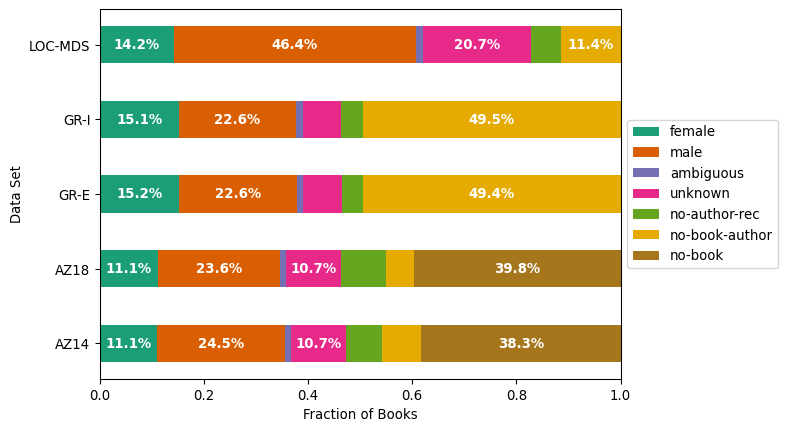

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

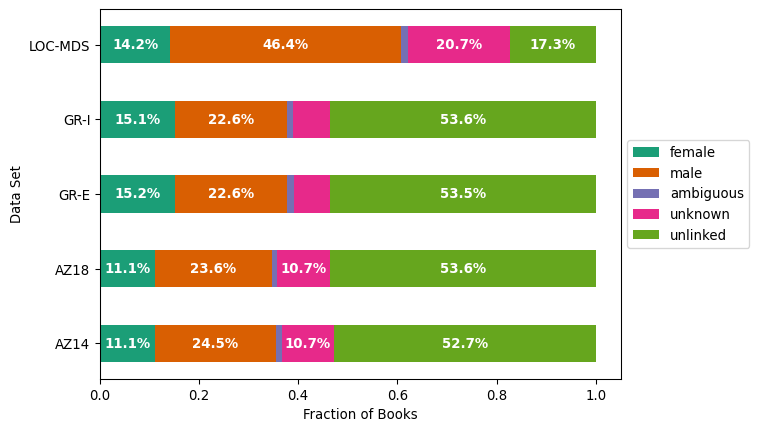

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

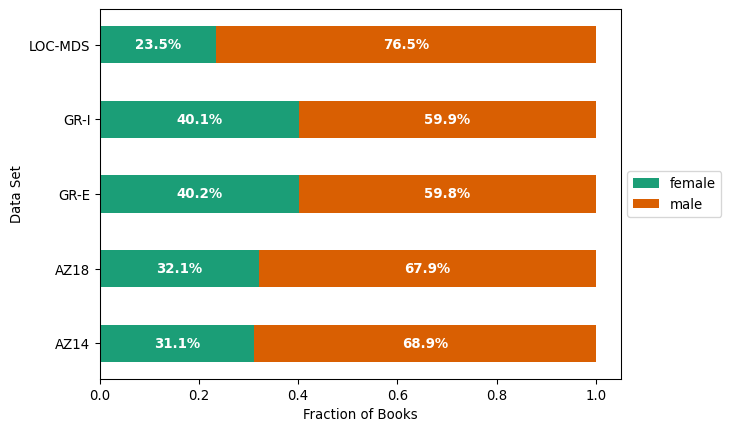

In [14]:
plot_bars(fractionalize(book_counts, ["female", "male"]))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

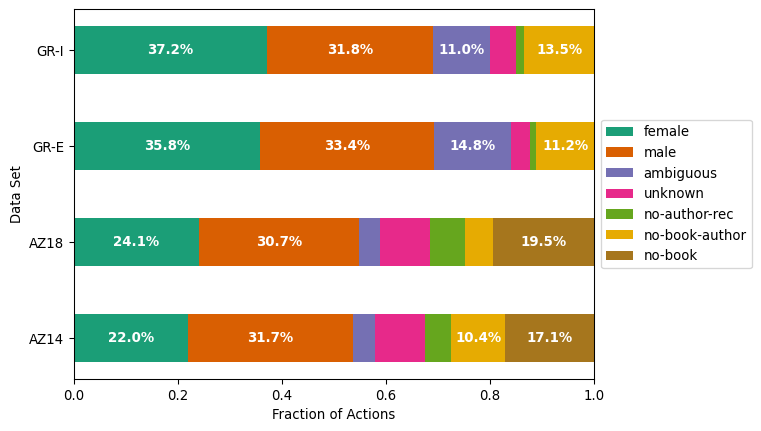

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes), item="Actions")

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

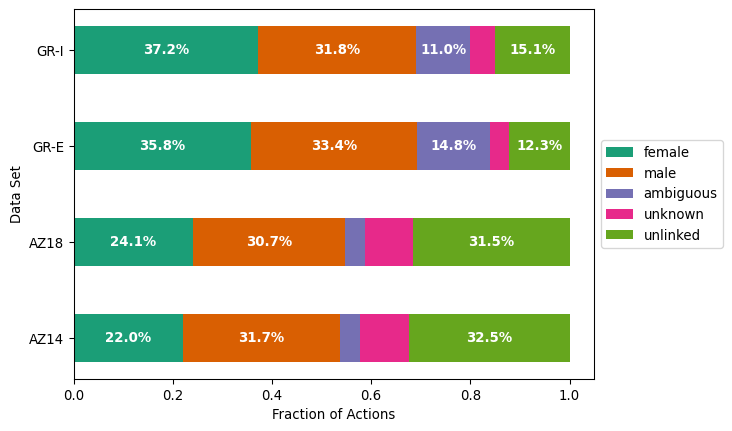

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes), item="Actions")

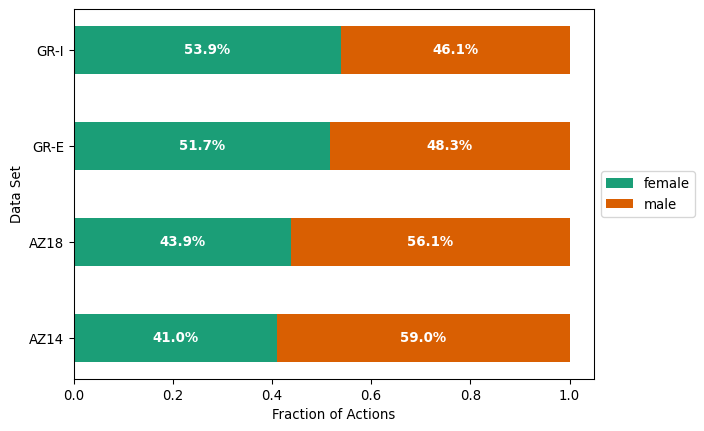

In [19]:
plot_bars(fractionalize(act_counts, ["female", "male"]), item="Actions")

## Metrics

Finally, we’re going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts["male"] + book_counts["female"] + book_counts["ambiguous"]
book_cover = book_link / book_tots
book_cover

dataset
AZ14       0.366434
AZ18       0.357075
GR-E       0.391122
GR-I       0.390052
LOC-MDS    0.620765
dtype: float64

In [21]:
book_cover.to_json("book-coverage.json")